# Payment Transaction Volume Forecasting — EDA

**Goal:** Explore the bank transaction dataset, aggregate to daily time series, and perform
time series analysis (decomposition, stationarity, ACF/PACF) to prepare for modeling.

**Why EDA first?** We need to understand the data's structure — trends, seasonality,
stationarity — before choosing the right forecasting model. A SARIMA model needs
different prep than XGBoost.

## Step 1: Load & Inspect Raw Data

**Why:** Before any transformation, we need to understand what columns exist,
their types, null counts, and sample values. This tells us what cleaning is needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df_raw = pd.read_csv('bank_clean.csv')
print(f'Shape: {df_raw.shape}')
print(f'\nColumn types & nulls:')
df_raw.info()
print(f'\nDuplicates: {df_raw.duplicated().sum()}')
df_raw.head()

Shape: (116201, 8)

Column types & nulls:
<class 'pandas.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   account_no           116201 non-null  int64  
 1   date                 116201 non-null  str    
 2   transaction_details  113702 non-null  str    
 3   cheque_no            905 non-null     float64
 4   value_date           116201 non-null  str    
 5   withdrawal_amt       53549 non-null   float64
 6   deposit_amt          62652 non-null   float64
 7   balance_amt          116201 non-null  float64
dtypes: float64(4), int64(1), str(3)
memory usage: 7.1 MB

Duplicates: 39


,account_no,date,transaction_details,cheque_no,value_date,withdrawal_amt,deposit_amt,balance_amt
0,409000611074,2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0
1,409000611074,2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0
2,409000611074,2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0
3,409000611074,2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0
4,409000611074,2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0


In [2]:
df_raw.sample(5)

,account_no,date,transaction_details,cheque_no,value_date,withdrawal_amt,deposit_amt,balance_amt
1173,409000493201,2017-03-22,BBPS OX01 SETTLEMENT 22.0,NaN,2017-03-22,78583.40,NaN,7.420122e+05
82900,1196428,2018-11-14,IMPS 831822185871 FROM GA,NaN,2018-11-14,NaN,200000.0,-1.676592e+09
69614,1196428,2017-12-28,FDRL/REAL TIME GROSS SETTL,NaN,2017-12-28,3000000.00,NaN,-1.689333e+09
65507,1196428,2017-09-05,NEFT/N248170361957699/PAY,NaN,2017-09-05,NaN,1395647.9,-1.667036e+09
1103,409000493201,2016-11-01,BBPS SETTLEMENT FOR DT 31,NaN,2016-11-01,1015.71,NaN,9.586448e+05


## Step 2: Data Cleaning

**What we drop and why:**
- `cheque_no` — 99.2% null, zero predictive value for aggregate forecasting
- `balance_amt` — account-level running balance, not a flow metric

**What we keep and why:**
- `account_no` — needed to count unique customers per day (dropped AFTER aggregation)
- `transaction_details` — needed for transaction type mix ratios (dropped AFTER aggregation)
- `value_date` — settlement date = when money actually moves (used for aggregation)
- `date` — transaction initiation date (compare with value_date, then drop)
- `withdrawal_amt`, `deposit_amt` — our core amount columns

In [3]:
# Check: do 'date' and 'value_date' differ?
# If they differ, value_date is the correct one for liquidity (settlement date)
date_mismatch = (df_raw['date'] != df_raw['value_date']).sum()
print(f'Rows where date != value_date: {date_mismatch} out of {len(df_raw)} ({date_mismatch/len(df_raw)*100:.1f}%)')

Rows where date != value_date: 135 out of 116201 (0.1%)


In [4]:
# Drop columns with no forecasting value
df = df_raw.drop(columns=['cheque_no', 'balance_amt'])

# Drop exact duplicates
df = df.drop_duplicates()
print(f'Shape after cleaning: {df.shape}')

# Fill NaN in amounts with 0 (a row is either a withdrawal OR a deposit, not both)
df['withdrawal_amt'] = df['withdrawal_amt'].fillna(0)
df['deposit_amt'] = df['deposit_amt'].fillna(0)

# Parse dates
df['value_date'] = pd.to_datetime(df['value_date'])

df.head()

Shape after cleaning: (100400, 6)


,account_no,date,transaction_details,value_date,withdrawal_amt,deposit_amt
0,409000611074,2017-06-29,TRF FROM Indiaforensic SERVICES,2017-06-29,0.0,1000000.0
1,409000611074,2017-07-05,TRF FROM Indiaforensic SERVICES,2017-07-05,0.0,1000000.0
2,409000611074,2017-07-18,FDRL/INTERNAL FUND TRANSFE,2017-07-18,0.0,500000.0
3,409000611074,2017-08-01,TRF FRM Indiaforensic SERVICES,2017-08-01,0.0,3000000.0
4,409000611074,2017-08-16,FDRL/INTERNAL FUND TRANSFE,2017-08-16,0.0,500000.0


## Step 3: Aggregation Pipeline — Raw Transactions to Daily Time Series

**Why:** Our raw data has one row per transaction. We need to aggregate to daily level
because we're forecasting *daily* volumes and amounts.

**What we compute per day:**
- `transaction_volume` = COUNT of all transactions → drives **infrastructure planning**
- `deposit_amt` = SUM of deposits → money flowing IN
- `withdrawal_amt` = SUM of withdrawals → money flowing OUT
- `net_flow` = deposits - withdrawals → drives **liquidity planning**
- `unique_accounts` = COUNT of distinct accounts transacting

In [5]:
daily = (
    df
    .groupby('value_date')
    .agg(
        transaction_volume=('value_date', 'size'),
        total_withdrawal=('withdrawal_amt', 'sum'),
        total_deposit=('deposit_amt', 'sum'),
        unique_accounts=('account_no', 'nunique')
    )
)

# Net flow = deposits - withdrawals (positive = surplus, negative = deficit)
daily['net_flow'] = daily['total_deposit'] - daily['total_withdrawal']

print(f'Daily aggregated shape: {daily.shape}')
print(f'Date range: {daily.index.min()} to {daily.index.max()}')
daily.head(10)

Daily aggregated shape: (1294, 5)
Date range: 2015-01-01 00:00:00 to 2019-03-05 00:00:00


,transaction_volume,total_withdrawal,total_deposit,unique_accounts,net_flow
value_date,,,,,
2015-01-01,3,0.00,2004999.0,2,2004999.00
2015-01-02,10,5500056.18,2465620.0,2,-3034436.18
2015-01-03,4,2200000.00,2948160.0,1,748160.00
2015-01-05,12,3231000.00,3909020.0,2,678020.00
2015-01-06,6,3880056.18,3650750.0,1,-229306.18
2015-01-07,4,3650000.00,3455070.0,1,-194930.00
2015-01-08,4,3450000.00,4550200.0,1,1100200.00
2015-01-09,4,4550000.00,4902100.0,1,352100.00
2015-01-10,12,3901500.00,5614880.0,1,1713380.00


## Step 4: Handle Missing Dates

**Why:** Time series models (ARIMA, SARIMA) expect a continuous date index with no gaps.
If Jan 3 and Jan 5 exist but Jan 4 is missing, the model doesn't know a day was skipped.

**Approach:**
1. Create a complete date range from min to max date
2. Reindex — days with no transactions become NaN
3. Fill NaN: volume = 0, amounts = 0 (no transactions means zero, not unknown)

In [6]:
# Create complete date range
full_range = pd.date_range(start=daily.index.min(), end=daily.index.max(), freq='D')

# How many dates are missing?
missing_dates = full_range.difference(daily.index)
print(f'Missing dates: {len(missing_dates)} out of {len(full_range)} total days')

# Reindex and fill: no transaction = 0 volume, 0 amount
daily = daily.reindex(full_range)
daily.index.name = 'date'
daily[['transaction_volume', 'total_withdrawal', 'total_deposit', 'net_flow', 'unique_accounts']] = \
    daily[['transaction_volume', 'total_withdrawal', 'total_deposit', 'net_flow', 'unique_accounts']].fillna(0)

# Convert volume and unique_accounts to int
daily['transaction_volume'] = daily['transaction_volume'].astype(int)
daily['unique_accounts'] = daily['unique_accounts'].astype(int)

print(f'\nFinal daily shape: {daily.shape}')
daily.head(10)

Missing dates: 231 out of 1525 total days

Final daily shape: (1525, 5)


,transaction_volume,total_withdrawal,total_deposit,unique_accounts,net_flow
date,,,,,
2015-01-01,3,0.00,2004999.0,2,2004999.00
2015-01-02,10,5500056.18,2465620.0,2,-3034436.18
2015-01-03,4,2200000.00,2948160.0,1,748160.00
2015-01-04,0,0.00,0.0,0,0.00
2015-01-05,12,3231000.00,3909020.0,2,678020.00
2015-01-06,6,3880056.18,3650750.0,1,-229306.18
2015-01-07,4,3650000.00,3455070.0,1,-194930.00
2015-01-08,4,3450000.00,4550200.0,1,1100200.00
2015-01-09,4,4550000.00,4902100.0,1,352100.00


## Step 5: Visualize the Time Series

**Why:** Before any statistical test, visually inspect the data.
We're looking for:
- **Trend** — is volume increasing/decreasing over time?
- **Seasonality** — weekly cycles? month-end spikes?
- **Outliers** — any extreme days that could distort models?
- **Net flow direction** — are there prolonged deficit periods?

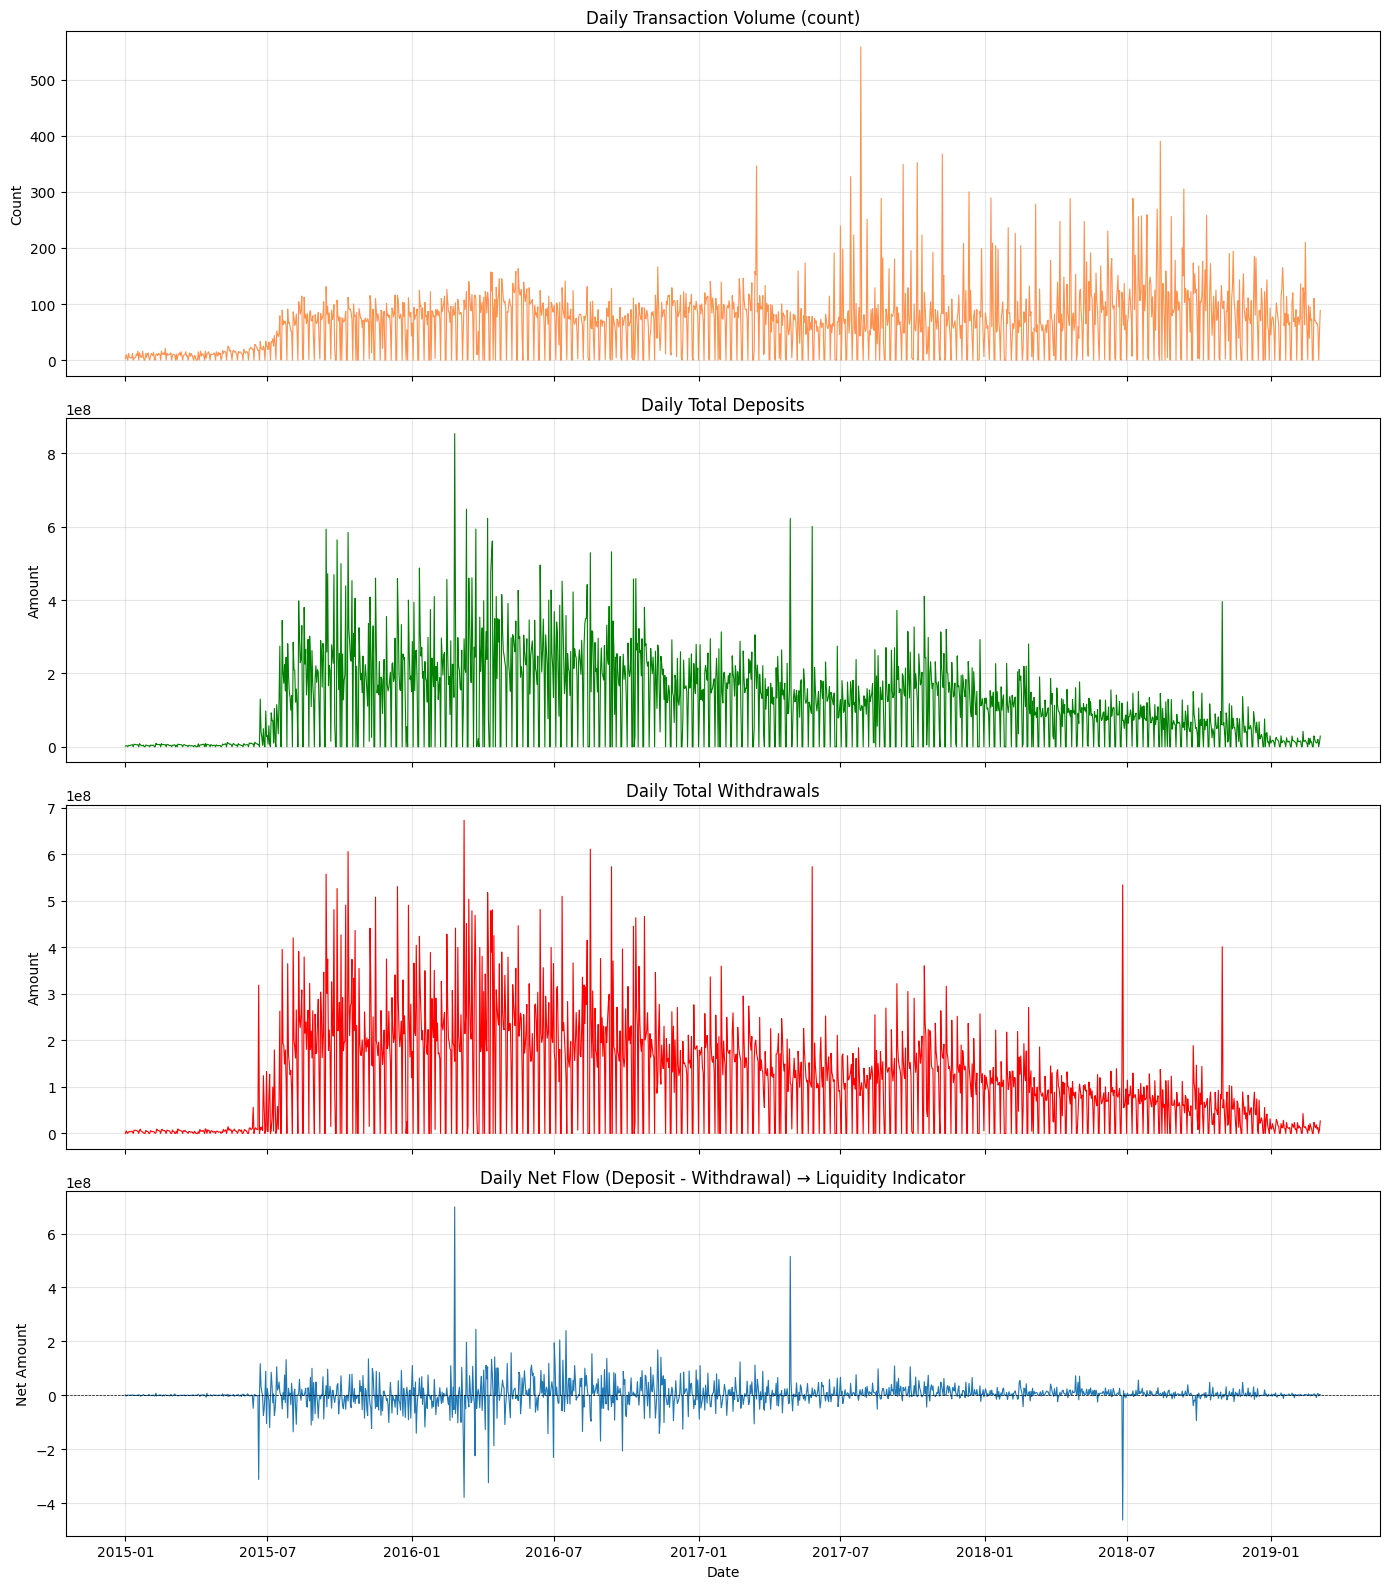

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Transaction Volume
axes[0].plot(daily.index, daily['transaction_volume'], color='#FF914D', linewidth=0.8)
axes[0].set_title('Daily Transaction Volume (count)')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# Total Deposits
axes[1].plot(daily.index, daily['total_deposit'], color='green', linewidth=0.8)
axes[1].set_title('Daily Total Deposits')
axes[1].set_ylabel('Amount')
axes[1].grid(True, alpha=0.3)

# Total Withdrawals
axes[2].plot(daily.index, daily['total_withdrawal'], color='red', linewidth=0.8)
axes[2].set_title('Daily Total Withdrawals')
axes[2].set_ylabel('Amount')
axes[2].grid(True, alpha=0.3)

# Net Flow
axes[3].plot(daily.index, daily['net_flow'], color='#1f77b4', linewidth=0.8)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[3].set_title('Daily Net Flow (Deposit - Withdrawal) → Liquidity Indicator')
axes[3].set_ylabel('Net Amount')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Distributional Properties

**Why:** Check if transaction volume / amounts are normally distributed or skewed.
Skewed data may need log transformation before modeling.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

daily['transaction_volume'].hist(bins=50, ax=axes[0], color='#FF914D', edgecolor='black')
axes[0].set_title('Distribution: Transaction Volume')

daily['total_deposit'].hist(bins=50, ax=axes[1], color='green', edgecolor='black')
axes[1].set_title('Distribution: Daily Deposits')

daily['net_flow'].hist(bins=50, ax=axes[2], color='#1f77b4', edgecolor='black')
axes[2].set_title('Distribution: Net Flow')

plt.tight_layout()
plt.show()

print('Summary Statistics:')
daily[['transaction_volume', 'total_deposit', 'total_withdrawal', 'net_flow']].describe()

### Day-of-Week & Month-End Patterns

**Why:** Payment data typically shows strong day-of-week effects (weekends are quieter)
and month-end spikes (salary payments, bill settlements). Confirming these patterns
tells us seasonality exists and SARIMA / calendar features will be valuable.

In [ ]:
import seaborn as sns

daily['day_of_week'] = daily.index.day_name()
daily['is_month_end'] = daily.index.is_month_end

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volume by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=daily, x='day_of_week', y='transaction_volume', order=day_order, ax=axes[0],
            palette='Oranges')
axes[0].set_title('Transaction Volume by Day of Week')
axes[0].tick_params(axis='x', rotation=45)

# Volume: month-end vs normal days
sns.boxplot(data=daily, x='is_month_end', y='transaction_volume', ax=axes[1],
            palette='Oranges')
axes[1].set_title('Transaction Volume: Month-End vs Normal Days')
axes[1].set_xticklabels(['Normal Days', 'Month-End'])

plt.tight_layout()
plt.show()

# Clean up temp columns
daily.drop(columns=['day_of_week', 'is_month_end'], inplace=True)

## Step 6: Time Series Decomposition

**Why:** Decomposition separates a time series into 3 components:
- **Trend** — long-term increase/decrease
- **Seasonality** — repeating patterns (weekly, monthly cycles)
- **Residual** — what's left after removing trend + seasonality (noise / irregular events)

This tells us:
- Does a trend exist? → determines if differencing is needed
- How strong is seasonality? → determines if SARIMA (seasonal) is better than ARIMA
- Are residuals random? → if not, the model can capture more signal

**Two approaches:**
1. Classical decomposition (additive) — assumes components add up: Y = Trend + Seasonal + Residual
2. STL decomposition — more robust, handles outliers better

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Classical Additive Decomposition on transaction volume
# period=7 because we expect weekly seasonality (7 days)
decomp = seasonal_decompose(daily['transaction_volume'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomp.observed.plot(ax=axes[0], color='#FF914D')
axes[0].set_ylabel('Observed')
decomp.trend.plot(ax=axes[1], color='#FF914D')
axes[1].set_ylabel('Trend')
decomp.seasonal.plot(ax=axes[2], color='#FF914D')
axes[2].set_ylabel('Seasonal')
decomp.resid.plot(ax=axes[3], color='#FF914D')
axes[3].set_ylabel('Residual')

fig.suptitle('Classical Additive Decomposition — Daily Transaction Volume (period=7)', y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
# STL Decomposition — more robust to outliers
# Why STL over classical? STL uses LOESS (locally weighted regression)
# so it handles irregular spikes better than moving-average-based classical decomposition

stl = STL(daily['transaction_volume'], period=7)
result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
result.observed.plot(ax=axes[0], color='#FF914D')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], color='#FF914D')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], color='#FF914D')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], color='#FF914D')
axes[3].set_ylabel('Residual')

fig.suptitle('STL Decomposition — Daily Transaction Volume (period=7)', y=1.01)
plt.tight_layout()
plt.show()

## Step 7: Stationarity Testing

**Why this matters:** Most time series models (ARIMA, SARIMA) require the data to be
**stationary** — meaning constant mean, constant variance, no trend over time.

If the data is non-stationary, the model will learn spurious patterns and forecast poorly.

**Two complementary tests:**

| Test | Null Hypothesis | Reject means |
|------|----------------|---------------|
| ADF  | Series has a unit root (non-stationary) | Series IS stationary |
| KPSS | Series is stationary | Series is NOT stationary |

We run both because they test different things. If both agree, we're confident.
If they disagree, the series may be trend-stationary (needs differencing).

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f'--- ADF Test: {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    for key, val in result[4].items():
        print(f'  Critical Value ({key}): {val:.4f}')
    if result[1] < 0.05:
        print('→ REJECT null hypothesis: Series IS stationary')
    else:
        print('→ FAIL to reject: Series is NON-stationary')
    print()

def run_kpss_test(series, name=''):
    result = kpss(series.dropna(), regression='ct')
    print(f'--- KPSS Test: {name} ---')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    for key, val in result[3].items():
        print(f'  Critical Value ({key}): {val:.4f}')
    if result[1] < 0.05:
        print('→ REJECT null hypothesis: Series is NON-stationary')
    else:
        print('→ FAIL to reject: Series IS stationary')
    print()

# Test on transaction volume (raw)
run_adf_test(daily['transaction_volume'], 'Transaction Volume (raw)')
run_kpss_test(daily['transaction_volume'], 'Transaction Volume (raw)')

In [ ]:
# Test on net_flow (raw)
run_adf_test(daily['net_flow'], 'Net Flow (raw)')
run_kpss_test(daily['net_flow'], 'Net Flow (raw)')

## Step 8: Making Data Stationary (if needed)

**If the tests show non-stationarity, we apply differencing.**

**What is differencing?**
Instead of modeling the raw value Y(t), we model the CHANGE: Y(t) - Y(t-1).
This removes trends because a constant upward trend becomes a constant number after differencing.

**Why not log transform?** Log works when variance grows with the level (multiplicative).
For transaction counts, variance is often additive, so differencing is usually sufficient.

We then re-run stationarity tests to confirm differencing worked.

In [ ]:
# First-order differencing
volume_diff = daily['transaction_volume'].diff().dropna()
net_flow_diff = daily['net_flow'].diff().dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original vs Differenced: Volume
axes[0, 0].plot(daily['transaction_volume'], color='#FF914D', linewidth=0.8)
axes[0, 0].set_title('Transaction Volume — Original')
axes[0, 1].plot(volume_diff, color='#FF914D', linewidth=0.8)
axes[0, 1].set_title('Transaction Volume — After 1st Differencing')

# Original vs Differenced: Net Flow
axes[1, 0].plot(daily['net_flow'], color='#1f77b4', linewidth=0.8)
axes[1, 0].set_title('Net Flow — Original')
axes[1, 1].plot(net_flow_diff, color='#1f77b4', linewidth=0.8)
axes[1, 1].set_title('Net Flow — After 1st Differencing')

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Re-test stationarity after differencing
print('=== After 1st Differencing ===')
run_adf_test(volume_diff, 'Transaction Volume (differenced)')
run_kpss_test(volume_diff, 'Transaction Volume (differenced)')
run_adf_test(net_flow_diff, 'Net Flow (differenced)')
run_kpss_test(net_flow_diff, 'Net Flow (differenced)')

### Ljung-Box Test — Is it White Noise or Random Walk?

**Why:** After differencing, we need to check if the series still has autocorrelation
(today's value is correlated with yesterday's). If it does → forecastable. If not → white noise
(random, cannot be forecast).

- **H0:** No autocorrelation (white noise)
- **H1:** Autocorrelation exists (forecastable)
- If p < 0.05 → reject H0 → data IS forecastable

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test on raw volume
print('Ljung-Box Test: Transaction Volume (raw)')
lb_raw = acorr_ljungbox(daily['transaction_volume'], lags=[7, 14, 30], return_df=True)
print(lb_raw)

print('\nLjung-Box Test: Transaction Volume (differenced)')
lb_diff = acorr_ljungbox(volume_diff, lags=[7, 14, 30], return_df=True)
print(lb_diff)

## Step 9: ACF & PACF Plots

**Why:** These plots directly tell us the order of AR and MA components for ARIMA.

- **ACF (Autocorrelation Function):** Shows correlation between Y(t) and Y(t-k) for each lag k.
  - If ACF cuts off sharply after lag q → use MA(q)
  - If ACF decays slowly → AR component is dominant

- **PACF (Partial Autocorrelation Function):** Shows correlation between Y(t) and Y(t-k)
  AFTER removing the effect of intermediate lags.
  - If PACF cuts off sharply after lag p → use AR(p)
  - If PACF decays slowly → MA component is dominant

**Rules for ARIMA(p, d, q):**
- d = number of differencings needed (from Step 8)
- p = read from PACF (where it cuts off)
- q = read from ACF (where it cuts off)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ACF & PACF on differenced transaction volume
plot_acf(volume_diff, ax=axes[0, 0], lags=40, color='#FF914D')
axes[0, 0].set_title('ACF — Transaction Volume (differenced)')

plot_pacf(volume_diff, ax=axes[0, 1], lags=40, method='ywm', color='#FF914D')
axes[0, 1].set_title('PACF — Transaction Volume (differenced)')

# ACF & PACF on differenced net flow
plot_acf(net_flow_diff, ax=axes[1, 0], lags=40, color='#1f77b4')
axes[1, 0].set_title('ACF — Net Flow (differenced)')

plot_pacf(net_flow_diff, ax=axes[1, 1], lags=40, method='ywm', color='#1f77b4')
axes[1, 1].set_title('PACF — Net Flow (differenced)')

plt.tight_layout()
plt.show()

## Step 10: Smoothing Methods — Trend Visualization

**Why:** Smoothing removes short-term noise to reveal the underlying trend.
This is not for forecasting itself — it's for understanding.

**Three methods compared:**
- **SMA (Simple Moving Average):** Equal weight to all days in window. Lags behind turns.
- **WMA (Weighted Moving Average):** Recent days get higher weight. Reacts faster than SMA.
- **EMA (Exponential Moving Average):** Exponentially decaying weights. Fastest response to recent changes.

For our forecasting, these smoothed values will later become features (rolling_mean_7, rolling_mean_30).

In [ ]:
window = 7  # 7-day window (weekly smoothing)

plt.figure(figsize=(14, 6))

plt.plot(daily['transaction_volume'], label='Raw Volume', color='lightgrey', linewidth=0.8)

# SMA
sma = daily['transaction_volume'].rolling(window=window).mean()
plt.plot(sma, label=f'SMA ({window}-day)', color='green', linewidth=1.5)

# WMA
weights = np.arange(1, window + 1)
wma = daily['transaction_volume'].rolling(window).apply(
    lambda x: np.dot(x, weights) / weights.sum(), raw=True)
plt.plot(wma, label=f'WMA ({window}-day)', color='orange', linewidth=1.5)

# EMA
ema = daily['transaction_volume'].ewm(span=window).mean()
plt.plot(ema, label=f'EMA ({window}-day)', color='red', linewidth=1.5)

plt.title('Transaction Volume — Smoothing Comparison (7-day window)')
plt.xlabel('Date')
plt.ylabel('Transaction Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Also compare with 30-day smoothing for longer-term trend
window_long = 30

plt.figure(figsize=(14, 6))

plt.plot(daily['transaction_volume'], label='Raw Volume', color='lightgrey', linewidth=0.8)

sma_30 = daily['transaction_volume'].rolling(window=window_long).mean()
plt.plot(sma_30, label=f'SMA ({window_long}-day)', color='green', linewidth=2)

ema_30 = daily['transaction_volume'].ewm(span=window_long).mean()
plt.plot(ema_30, label=f'EMA ({window_long}-day)', color='red', linewidth=2)

plt.title('Transaction Volume — 30-Day Smoothing (Long-Term Trend)')
plt.xlabel('Date')
plt.ylabel('Transaction Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 11: Resampling — Weekly Aggregation

**Why:** The problem statement requires forecasting at both daily AND weekly levels.
Weekly aggregation smooths out day-to-day noise, so weekly MAPE target is tighter (<10% vs <15%).

Downsampling daily → weekly using sum for amounts/volume.

In [ ]:
weekly = daily.resample('W').agg({
    'transaction_volume': 'sum',
    'total_deposit': 'sum',
    'total_withdrawal': 'sum',
    'net_flow': 'sum',
    'unique_accounts': 'max'
})

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(weekly['transaction_volume'], color='#FF914D', marker='o', markersize=3)
axes[0].set_title('Weekly Transaction Volume')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

axes[1].plot(weekly['net_flow'], color='#1f77b4', marker='o', markersize=3)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_title('Weekly Net Flow (Liquidity Position)')
axes[1].set_ylabel('Net Amount')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Weekly aggregated shape: {weekly.shape}')
weekly.head(10)

## Step 12: Train / Validation / Test Split Strategy

**Why time-based split (not random)?** In time series, future data must NEVER leak into training.
A random 80/20 split would let the model see Dec data while predicting Oct — that's cheating.

**Split:**
- Train: Everything except last 60 days
- Validation: Next 30 days (for hyperparameter tuning)
- Test: Last 30 days (final evaluation, untouched until the end)

In [ ]:
test_days = 30
val_days = 30

train = daily.iloc[:-(test_days + val_days)]
val = daily.iloc[-(test_days + val_days):-test_days]
test = daily.iloc[-test_days:]

print(f'Train: {train.index.min()} to {train.index.max()} ({len(train)} days)')
print(f'Val:   {val.index.min()} to {val.index.max()} ({len(val)} days)')
print(f'Test:  {test.index.min()} to {test.index.max()} ({len(test)} days)')

# Visualize the split
plt.figure(figsize=(14, 4))
plt.plot(train.index, train['transaction_volume'], color='blue', label='Train')
plt.plot(val.index, val['transaction_volume'], color='orange', label='Validation')
plt.plot(test.index, test['transaction_volume'], color='red', label='Test')
plt.title('Train / Validation / Test Split — No Future Leakage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 13: Save Processed Data

Save the aggregated daily and weekly datasets for use in modeling notebooks.

In [ ]:
daily.to_csv('daily_aggregated.csv')
weekly.to_csv('weekly_aggregated.csv')

print('Saved: daily_aggregated.csv')
print('Saved: weekly_aggregated.csv')
print(f'\nDaily columns: {list(daily.columns)}')
print(f'Weekly columns: {list(weekly.columns)}')

## EDA Summary & Key Findings

| Step | What We Did | Why It Matters |
|------|------------|----------------|
| Data Cleaning | Dropped cheque_no, balance_amt; kept value_date for settlement | Correct aggregation date for liquidity |
| Aggregation | Raw txns → daily volume, deposit, withdrawal, net_flow | Created our forecast targets |
| Missing Dates | Reindexed to continuous calendar, filled with 0 | ARIMA needs continuous time index |
| Visualization | Plotted trends, day-of-week, month-end patterns | Confirmed seasonality exists |
| Decomposition | Classical + STL with period=7 | Separated trend, weekly seasonality, residuals |
| Stationarity | ADF + KPSS tests | Determined if differencing is needed (d parameter) |
| Differencing | First-order diff, then re-tested | Made series stationary for ARIMA |
| Ljung-Box | Autocorrelation test | Confirmed data IS forecastable (not white noise) |
| ACF/PACF | Plotted to identify p, q orders | Guides ARIMA(p,d,q) selection |
| Smoothing | SMA, WMA, EMA at 7-day and 30-day | Revealed long-term trend direction |
| Resampling | Daily → weekly aggregation | Secondary forecast target (tighter MAPE) |
| Split | Time-based train/val/test | No data leakage guaranteed |

**Next step:** Use these findings to build ARIMA/SARIMA baseline (Week 2 deliverable).